In [1]:
from functional import *
from rnn_forecast import timeseries_rnn
from lstm_forecast import timeseries_lstm
from transformer_forecast import timeseries_transformer
from sklearn.metrics import mean_absolute_error,mean_absolute_percentage_error

2024-09-27 00:42:39.214596: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-27 00:42:39.228305: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-27 00:42:39.232079: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-27 00:42:39.242761: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-27 00:42:39.987118: W tensorflow/compiler/tf2

In [2]:
class evaluate_compare(funtional):
    def __init__(self):
        super().__init__()
        self.rnn=timeseries_rnn().build()
        self.rnn.load_weights(os.path.join(Path().cwd(),f'models/rnn_{self.price_type}_{self.symbol}_{self.timeframe}.weights.h5'))

        self.lstm=timeseries_lstm().build()
        self.lstm.load_weights(os.path.join(Path().cwd(),f'models/lstm_{self.price_type}_{self.symbol}_{self.timeframe}.weights.h5'))

        self.transformer=timeseries_transformer().build()
        self.transformer.load_weights(os.path.join(Path().cwd(),f'models/transformer_{self.price_type}_{self.symbol}_{self.timeframe}.weights.h5'))

        self.model_selection={'transformer':self.transformer,'rnn':self.rnn,'lstm':self.lstm}

    def sape(self,true_value,predict_value):
        average_volatility=pd.Series(true_value).pct_change().abs().mean()
        mape=mean_absolute_percentage_error(true_value,predict_value)
        scaled_perentage_error=mape/average_volatility
        return scaled_perentage_error

    def plot_all(self):
        self.draw=pd.DataFrame({
            'True values':self.y,
            'RNN':self.rnn.predict(self.x).reshape(-1),
            'LSTM':self.lstm.predict(self.x).reshape(-1),
            'TRANSFORMER':self.transformer.predict(self.x).reshape(-1)
        },index=self.df.index[self.seq_length+1:])
        fg=plt.figure()
        ax=fg.add_subplot()
        self.draw.plot(ax=ax)
        ax.legend()
        ax.set_title(f'{self.symbol} {self.price_type}')

    def predict(self,true_value,predict_value):
        self.methods={'mae':mean_absolute_error,'mape':mean_absolute_percentage_error,'sape':self.sape}
        metrics,method_name=[],[]
        for name,method in self.methods.items():
            metrics.append(method(true_value,predict_value))
            method_name.append(name)
        return pd.Series(metrics,index=method_name)

    def compare(self):
        compare={}
        for name,model in self.model_selection.items():
            model_predict=model.predict(self.x).reshape(-1)
            compare[name]=self.predict(self.y,model_predict)
        return pd.DataFrame(compare)

In [3]:
evaluate=evaluate_compare()

2024-09-27 00:42:41.994420: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [4]:
evaluate.compare()

53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


,transformer,rnn,lstm
mae,0.006956,0.014772,0.011052
mape,0.006182,0.013726,0.010228
sape,2.111836,4.688763,3.493757


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
53/53 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


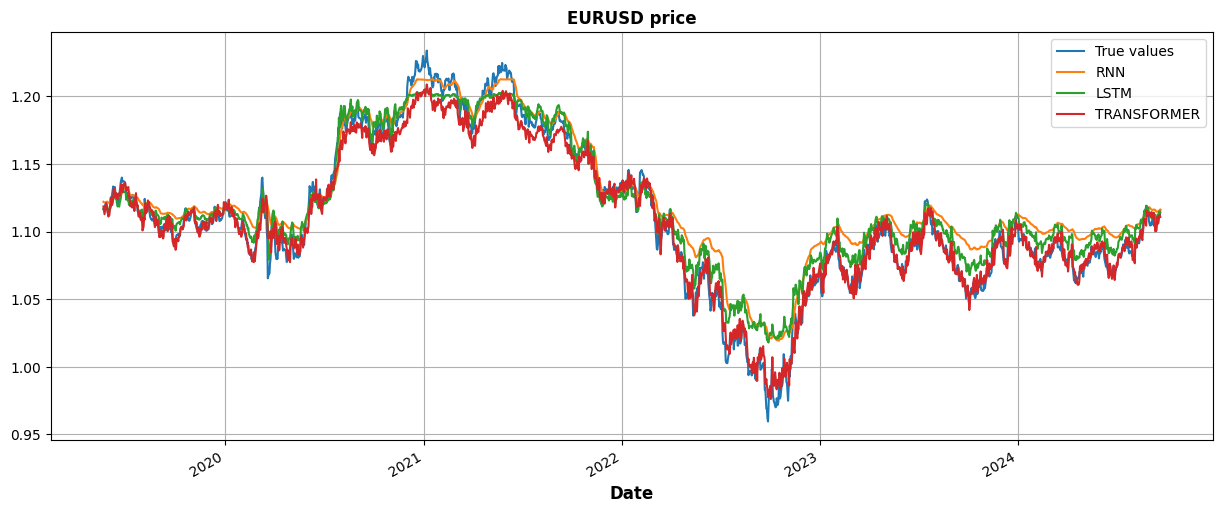

In [5]:
evaluate.plot_all()